In [ ]:
COLAB_PATH = '/content/drive/My Drive/Colab Notebooks/'

# **Load the Models**

In [ ]:
# general purpose pytorch functions
import torch as t
# nn submodule for Neural Network structures
import torch.nn as nn
# function submodule for torch functions
import torch.nn.functional as F

# torchvision object to download image datasets
import torchvision.datasets as datasets
# torchvision object to load images
from torch.utils.data import DataLoader
# image transformations from torchvision
import torchvision.transforms as tr

# matplotlib to plot figures
import matplotlib.pyplot as plt

# package for manipulating files and directories
import os
# pacakge for dealing with tabular data
import pandas as pd
# package for math ops
import math
# numpy for array manipulation
import numpy as np

# **Load the Data**

In [80]:
# read in data
bank = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bank_data.csv')

# convert columns to categorical
# df[name] similar to the df$name notation
for col_name in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']:
    bank[col_name] = bank[col_name].astype('category')

# split into target vector and feature matrix (split X and Y)
bank_feats = bank.drop(columns=['y'])
bank_target = np.array(bank['y'])

# convert category variables to dummy variable encoding (similar to the model.matrix())
# can use drop_first=True in get_dummies to get rid of redundant first encoding
bank_feats = pd.get_dummies(bank_feats, drop_first=True)

bank_target = pd.get_dummies(bank_target, drop_first=True)
bank_target = np.asarray(bank_target).reshape(-1)


# split into training and test set (scikitlearn)
from sklearn.model_selection import train_test_split
bank_feat_train, bank_feat_test, bank_resp_train, bank_resp_test =\
    train_test_split(bank_feats, bank_target, test_size=0.25, random_state=123)

# scale columns (mean 0, var 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# get mean and standard deviation for each column according to train data
scaler.fit(bank_feat_train)
# scale columns of train and test data
bank_feat_train = scaler.transform(bank_feat_train)
bank_feat_test = scaler.transform(bank_feat_test)

# **Parameters for Learning**

In [64]:
####################
# ## PARAMETERS ## #
####################

# dictionary for experiment parameters
# can access using []. for examples, config['num_epochs']
config = {
    # foler to save results
    'exp_dir': COLAB_PATH + 'final_3/',

    # number of epochs (one epoch is one sweep through all training images, in a random order of batches)
    'num_epochs': 1000,

    # batch size (number of images to use for each stochastic gradient learning iteration)
    'batch_size': 32
}

# **Build the Network**

In [65]:
#################
# ## NETWORK ## #
#################

class ClfBank(nn.Module):
    def __init__(self, in_nodes=42, num_classes=2):
        # initialize the parent class of ClfMNIST, the nn.Module class
        # if you are building a child class, generally initialize parent class firs
        super(ClfBank, self).__init__()

        # fully connected layers
        self.fc1 = nn.Linear(in_features=in_nodes, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=75)
        self.fc3 = nn.Linear(in_features=75, out_features=num_classes)

        # batch norm layers
        self.bn_fc1 = nn.BatchNorm1d(200)
        self.bn_fc2 = nn.BatchNorm1d(75)

        # collect all fc layers with nn.Sequential
        self.model_fc = nn.Sequential(
            self.fc1,
            self.bn_fc1,
            nn.ReLU(),
            self.fc2,
            self.bn_fc2,
            nn.ReLU(),
            self.fc3
        )

    def forward(self, x):
        logits = self.model_fc(x)
        return logits


# **Learning Process**


In [ ]:
###############
# ## SETUP ## #
###############

# make folder to save dataset
if not os.path.exists(config['exp_dir']):
    os.makedirs(config['exp_dir'])

print('Setting up network and optimizer...')
# network structure and weight init, put network on gpu with .cuda()
clf = ClfBank().cuda()
print(clf)

# initialize optim
# Adam optimizer is a widely used variant of SGD that scales learning rates for each parameter
# 1e-4 is good default value for the learning rate
optim = t.optim.Adam(clf.parameters(), lr=1e-4)

# loss criterion for logits
# maximum likelihood estimate for modeling categorical data y, the labels of the images
criterion = nn.CrossEntropyLoss()


###############################################
# ## FUNCTIONS FOR TRAIN AND TEST ## #
###############################################

# train model for single epoch through data
def train(epoch):
    # put the classifier in train mode
    # this unfreezes the BatchNorm layers to adapt to the data and new weights
    clf.train()

    # records for this epoch
    train_loss = 0
    correct = 0
    total = 0

    # shuffle the training data
    rand_inds = np.random.permutation(np.arange(bank_feat_train.shape[0]))
    feat_shuffle = bank_feat_train[rand_inds]
    resp_shuffle = bank_resp_train[rand_inds]

    # loop over batches of data
    for batch in range(math.ceil(float(bank_feat_train.shape[0]) / float(config['batch_size']))):
        # put states on gpu
        X_cpu = feat_shuffle[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_train.shape[0])]
        X_train = t.Tensor(X_cpu).cuda()
        y_cpu = resp_shuffle[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_train.shape[0])]
        y_train = t.Tensor(y_cpu).long().cuda()

        # logits for prediction and loss for weight update 
        # forward pass through network
        logits = clf.forward(X_train)
        # compare network output to true 1-hot encodings from y
        loss = criterion(logits, y_train)

        # update classifier weights
        # first reset the gradient in the optimizer to 0 (don't forget to use this step before doing a backward pass)
        optim.zero_grad()
        # backward pass
        loss.backward()
        # use the optimizer to update the network weights
        optim.step()

        # record batch info
        # cross entropy loss that is being minimized
        train_loss += loss.item()
        # predictions for class (the index that maximizes the probability/minimizes the logits)
        _, y_pred = t.max(logits.detach(), 1)
        # update number of correct predictions
        correct += t.eq(y_pred, y_train).sum().cpu()
        # update total number of predictions
        total += y_train.nelement()

    # get accuracy and loss for the epoch
    train_acc = 100 * float(correct) / float(total)
    train_loss = train_loss / (batch+1)

    return train_acc, train_loss

# test model on withheld data
def test(epoch):
    # put the classifier in eval mode
    # this freezes the BatchNorm layers give deterministic output
    clf.eval()

    # records for this epoch
    test_loss = 0
    correct = 0
    total = 0

    # loop over batches of test data
    for batch in range(math.ceil(float(bank_feat_test.shape[0]) / float(config['batch_size']))):
        # put states on gpu
        X_cpu = bank_feat_test[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_test.shape[0])]
        X_test = t.Tensor(X_cpu).cuda()
        y_cpu = bank_resp_test[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_test.shape[0])]
        y_test = t.Tensor(y_cpu).long().cuda()

        # check test images
        with t.no_grad():

            # forward pass and get loss
            logits = clf(X_test)
            loss = criterion(logits, y_test)

            # record batch info (same as before)
            test_loss += loss.item()
            _, y_pred = t.max(logits, 1)
            correct += t.eq(y_pred, y_test).sum().cpu()
            total += y_test.nelement()

    # get and print test accuracy
    test_acc = 100 * float(correct) / float(total)
    test_loss = test_loss / (batch+1)

    return test_acc, test_loss


#######################
# ## LEARNING LOOP # ##
#######################

# empty list for plotting results
tr_acc_rec = []
tr_loss_rec = []
val_acc_rec = []
val_loss_rec = []

print('\nTraining has begun.')
for epoch in range(config['num_epochs']):
    print('Epoch {} of {}'.format(epoch+1, config['num_epochs']))

    # update model using train data
    tr_acc, tr_loss = train(epoch)
    # update record
    tr_acc_rec += [tr_acc]
    tr_loss_rec += [tr_loss]

    # evaluate test data
    val_acc, val_loss = test(epoch)
    # update record
    val_acc_rec += [val_acc]
    val_loss_rec += [val_loss]

    # save network weights checkpoint
    t.save(clf.state_dict(), config['exp_dir'] + 'clf.pth')
    # save optim
    t.save(optim.state_dict(), config['exp_dir'] + 'optim.pth')

    # save accuracy plot for training and testing data
    plt.plot(list(range(1, epoch+2)), tr_acc_rec, label='training data')
    plt.plot(list(range(1, epoch+2)), val_acc_rec, label='validation')
    plt.legend(loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show(config['exp_dir'] + 'acc_plot.png')
    plt.close()

    # save loss plot for training and testing data
    plt.plot(list(range(1, epoch+2)), tr_loss_rec, label='training data')
    plt.plot(list(range(1, epoch+2)), val_loss_rec, label='validation')
    plt.legend(loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show(config['exp_dir'] + 'loss_plot.png')
    plt.close()

print('Training has concluded.')

Overfitting begins to occur at approximately the 3rd epoch

# **New Parameters for Learning**

In [78]:
####################
# ## PARAMETERS ## #
####################

# dictionary for experiment parameters
# can access using []. for examples, config['num_epochs']
config = {
    # foler to save results
    'exp_dir': COLAB_PATH + 'final_3/',

    # number of epochs (one epoch is one sweep through all training images, in a random order of batches)
    'num_epochs': 3,

    # batch size (number of images to use for each stochastic gradient learning iteration)
    'batch_size': 32
}

# **Early Stopping Neural Network**

Setting up network and optimizer...
ClfBank(
  (fc1): Linear(in_features=42, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=75, bias=True)
  (fc3): Linear(in_features=75, out_features=2, bias=True)
  (bn_fc1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_fc2): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model_fc): Sequential(
    (0): Linear(in_features=42, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=75, bias=True)
    (4): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=75, out_features=2, bias=True)
  )
)

Training has begun.
Epoch 1 of 3


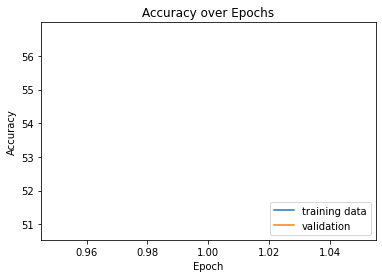

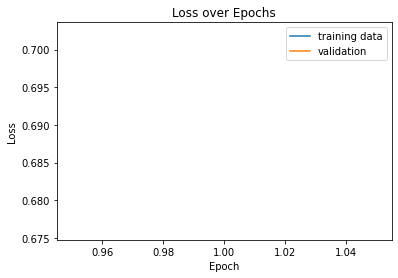

Epoch 2 of 3


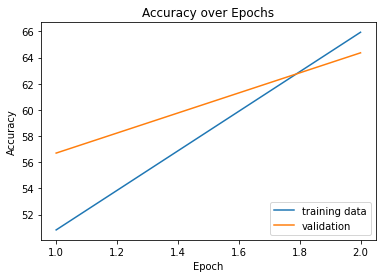

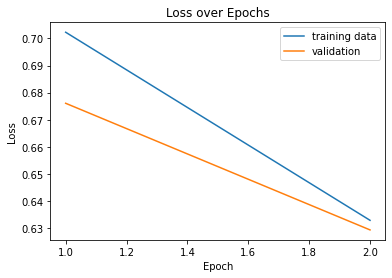

Epoch 3 of 3


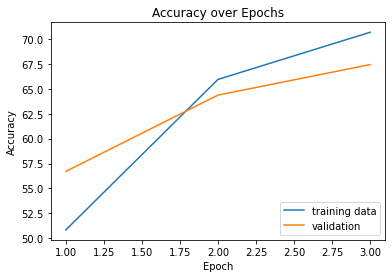

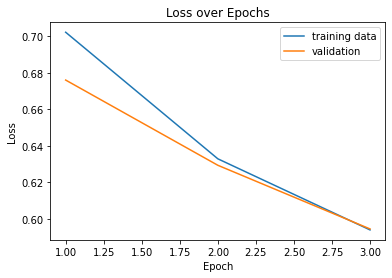

Training has concluded.


In [79]:
# make folder to save dataset
if not os.path.exists(config['exp_dir']):
    os.makedirs(config['exp_dir'])

print('Setting up network and optimizer...')
# network structure and weight init, put network on gpu with .cuda()
clf = ClfBank().cuda()
print(clf)

# initialize optim
# Adam optimizer is a widely used variant of SGD that scales learning rates for each parameter
# 1e-4 is good default value for the learning rate
optim = t.optim.Adam(clf.parameters(), lr=1e-4)

# loss criterion for logits
# maximum likelihood estimate for modeling categorical data y, the labels of the images
criterion = nn.CrossEntropyLoss()


###############################################
# ## FUNCTIONS FOR TRAIN AND TEST ## #
###############################################

# train model for single epoch through data
def train(epoch):
    # put the classifier in train mode
    # this unfreezes the BatchNorm layers to adapt to the data and new weights
    clf.train()

    # records for this epoch
    train_loss = 0
    correct = 0
    total = 0

    # shuffle the training data
    rand_inds = np.random.permutation(np.arange(bank_feat_train.shape[0]))
    feat_shuffle = bank_feat_train[rand_inds]
    resp_shuffle = bank_resp_train[rand_inds]

    # loop over batches of data
    for batch in range(math.ceil(float(bank_feat_train.shape[0]) / float(config['batch_size']))):
        # put states on gpu
        X_cpu = feat_shuffle[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_train.shape[0])]
        X_train = t.Tensor(X_cpu).cuda()
        y_cpu = resp_shuffle[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_train.shape[0])]
        y_train = t.Tensor(y_cpu).long().cuda()

        # logits for prediction and loss for weight update 
        # forward pass through network
        logits = clf.forward(X_train)
        # compare network output to true 1-hot encodings from y
        loss = criterion(logits, y_train)

        # update classifier weights
        # first reset the gradient in the optimizer to 0 (don't forget to use this step before doing a backward pass)
        optim.zero_grad()
        # backward pass
        loss.backward()
        # use the optimizer to update the network weights
        optim.step()

        # record batch info
        # cross entropy loss that is being minimized
        train_loss += loss.item()
        # predictions for class (the index that maximizes the probability/minimizes the logits)
        _, y_pred = t.max(logits.detach(), 1)
        # update number of correct predictions
        correct += t.eq(y_pred, y_train).sum().cpu()
        # update total number of predictions
        total += y_train.nelement()

    # get accuracy and loss for the epoch
    train_acc = 100 * float(correct) / float(total)
    train_loss = train_loss / (batch+1)

    return train_acc, train_loss

# test model on withheld data
def test(epoch):
    # put the classifier in eval mode
    # this freezes the BatchNorm layers give deterministic output
    clf.eval()

    # records for this epoch
    test_loss = 0
    correct = 0
    total = 0

    # loop over batches of test data
    for batch in range(math.ceil(float(bank_feat_test.shape[0]) / float(config['batch_size']))):
        # put states on gpu
        X_cpu = bank_feat_test[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_test.shape[0])]
        X_test = t.Tensor(X_cpu).cuda()
        y_cpu = bank_resp_test[(batch*config['batch_size']):min((batch+1)*config['batch_size'], bank_feat_test.shape[0])]
        y_test = t.Tensor(y_cpu).long().cuda()

        # check test images
        with t.no_grad():

            # forward pass and get loss
            logits = clf(X_test)
            loss = criterion(logits, y_test)

            # record batch info (same as before)
            test_loss += loss.item()
            _, y_pred = t.max(logits, 1)
            correct += t.eq(y_pred, y_test).sum().cpu()
            total += y_test.nelement()

    # get and print test accuracy
    test_acc = 100 * float(correct) / float(total)
    test_loss = test_loss / (batch+1)

    return test_acc, test_loss


#######################
# ## LEARNING LOOP # ##
#######################

# empty list for plotting results
tr_acc_rec = []
tr_loss_rec = []
val_acc_rec = []
val_loss_rec = []

print('\nTraining has begun.')
for epoch in range(config['num_epochs']):
    print('Epoch {} of {}'.format(epoch+1, config['num_epochs']))

    # update model using train data
    tr_acc, tr_loss = train(epoch)
    # update record
    tr_acc_rec += [tr_acc]
    tr_loss_rec += [tr_loss]

    # evaluate test data
    val_acc, val_loss = test(epoch)
    # update record
    val_acc_rec += [val_acc]
    val_loss_rec += [val_loss]

    # save network weights checkpoint
    t.save(clf.state_dict(), config['exp_dir'] + 'clf.pth')
    # save optim
    t.save(optim.state_dict(), config['exp_dir'] + 'optim.pth')

    # save accuracy plot for training and testing data
    plt.plot(list(range(1, epoch+2)), tr_acc_rec, label='training data')
    plt.plot(list(range(1, epoch+2)), val_acc_rec, label='validation')
    plt.legend(loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show(config['exp_dir'] + 'acc_plot.png')
    plt.close()

    # save loss plot for training and testing data
    plt.plot(list(range(1, epoch+2)), tr_loss_rec, label='training data')
    plt.plot(list(range(1, epoch+2)), val_loss_rec, label='validation')
    plt.legend(loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show(config['exp_dir'] + 'loss_plot.png')
    plt.close()

print('Training has concluded.')

# **ROC Curve and AUC for Training Data**

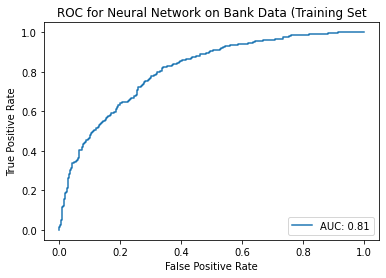

In [75]:
# make roc curve
from sklearn.metrics import roc_curve, auc

# predict probabilities for test data
# torch.no_grad() removes states from computational graph (use when no gradient is needed to save memory and time)
with t.no_grad():
    probs = F.softmax(clf.forward(t.Tensor(bank_feat_train).cuda()), dim=1)
# move to cpu then to numpy
probs = probs.cpu().numpy()
fpr, tpr, _ = roc_curve(bank_resp_train, probs[:,1])
auc_nn = auc(fpr, tpr)

# plot the info
plt.plot(fpr, tpr, label='AUC: {0:0.2f}'.format(auc_nn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Neural Network on Bank Data (Training Set')
plt.legend(loc='lower right')

# **ROC Curve and AUC for Test Data**

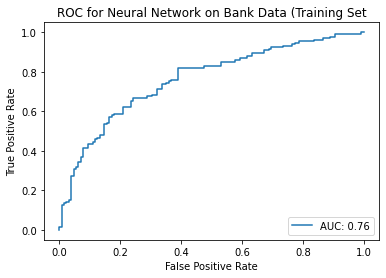

In [76]:
# make roc curve
from sklearn.metrics import roc_curve, auc

# predict probabilities for test data
# torch.no_grad() removes states from computational graph (use when no gradient is needed to save memory and time)
with t.no_grad():
    probs = F.softmax(clf.forward(t.Tensor(bank_feat_test).cuda()), dim=1)
# move to cpu then to numpy
probs = probs.cpu().numpy()
fpr, tpr, _ = roc_curve(bank_resp_test, probs[:,1])
auc_nn = auc(fpr, tpr)

# plot the info
plt.plot(fpr, tpr, label='AUC: {0:0.2f}'.format(auc_nn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Neural Network on Bank Data (Training Set')
plt.legend(loc='lower right')

There is noticeable overfitting on the training data but not to a severe extent